# Práctica de calibración de cámaras

Visión por Computador <br>
Practica 2. 2 de noviembre de 2020

**Autor 1:** Enol García González
<br>
**Autor 2:** César García Cabeza

Este enunciado está en el archivo "PracticaCalib2020.ipynb" o su versión "pdf" que puedes encontrar en el Aula Virtual.

## Objetivos


Los objetivos de esta práctica son:
* Calibrar una cámara usando el método de calibración de Zhang, implementado en OpenCV.
* Hacer uso de los resultados de la calibración para tomar diferentes medidas en las imágenes.
* Calibrar una cámara a partir de una imagen de una escena en la que se desconoce las coordenadas de sus puntos.

## Requerimientos

Para esta práctica es necesario disponer del siguiente software:
* Python 2.7 ó 3.X 
* Jupyter http://jupyter.org/.
* Las librerías científicas de Python: NumPy, SciPy, y Matplotlib.
* La librería OpenCV.

El material necesario para la práctica se puede descargar del Aula Virtual en la carpeta ``MaterialesPractica``. Esta
carpeta contiene:
* Dos secuencias de imágenes tomadas con un par de cámaras estéreo (izquierda y derecha) en los directorios ``left`` y ``right``.
* Un conjunto de imágenes de alta resolución un edificio, ``building``.

## Condiciones

* La fecha límite de entrega será el lunes 9 de noviembre a las 23:55.
* La entrega consiste en dos archivos con el código, resultados y respuestas a los ejercicios:
  1. Un "notebook" de Jupyter con los resultados. Las respuestas a los ejercicios debes introducirlas en tantas celdas de código o texto como creas necesarias, insertadas inmediatamente después de  un enuciado y antes del siguiente.
  2. Un documento "pdf" generado a partir del fuente de Jupyter, por ejemplo usando el comando ``jupyter nbconvert --execute --to pdf notebook.ipynb``, o simplemente imprimiendo el "notebook" desde el navegador en la opción del menú "File->Print preview". Asegúrate de que el documento "pdf" contiene todos los resultados correctamente ejecutados.
* Esta práctica puede realizarse en parejas.

## 1. Calibración de una cámara

En esta parte se trabajará con la secuencia de imágenes del directorio ``left``. Esta secuencia contiene una serie de imágenes de la plantilla de calibración. Para la calibración se debe tener en cuenta que el tamaño de cada escaque de la plantilla es de 30 mm en las direcciones X e Y.

In [1]:
# uncomment to show results in a window
# %matplotlib tk
import cv2
import glob
import copy
import numpy as np
import scipy.misc as scpm
import matplotlib.pyplot as plt
import imageio

Implementa la función ``load_images(filenames)`` que reciba una lista de nombres de archivos de imagen
y las cargue como matrices de NumPy. Usa la función ``scipy.misc.imread`` para cargar las imágenes. La función
debe devolver una lista de matrices de NumPy con las imágenes leídas.

In [2]:
# Función para cargar las imágenes dados los nombres
def load_images(filenames):
    """Load multiple images."""
    images = []
    for image in filenames:
        img = imageio.imread(image)
        images.append(img)
    return np.array(images)

Usa ``load_images`` para cargar todas las imágenes del directorio ``left`` por orden alfabético (la función ``glob.glob`` permite generar la lista de nombres de archivo, y, por ejemplo, la función ``sorted()`` de Python ordena alfabéticamente una lista de cadenas de texto).

In [3]:
# Cargamos las imágenes izquierda
images_left = glob.glob("B:/Proyectos/ComputerVision/Práctica2/left/*.jpg")
images_left = load_images(images_left)

La función ``cv2.findChessboardCorners`` de
OpenCV busca la plantilla de calibración en una imagen y
devuelve una tupla de dos elementos. El primer elemento
es 0 si no consiguió detectar correctamente la plantilla, y
es 1 en caso contrario. El segundo elemento contiene las
coordenadas de las esquinas de la plantilla de calibración,
que sólo son válidas si la detección fue exitosa, es decir, si
el primer elemento de la tupla es 1.

**Ejercicio 1.** Usa la  función ``cv2.findChessboardCorners``, y opcionalmente ``cv2.cornerSubPix``, para detectar automáticamente el patrón de calibración y sus esquinas en todas las imágenes cargadas. El tamaño de la plantilla de calibración en las imágenes
de la práctica es (8, 6) (*columnas x filas*). Almacena los resultados de las múltiples llamadas en
una lista, de modo que el elemento i de dicha lista corresponda al resultado de ``cv2.findChessboardCorners``
para la imagen i cargada anteriormente.


In [4]:
# Función para calcular los puntos del patrón en la imagen dadas las imágenes
def computeImagePoints(images):
    imgpoints = []
    for i, image in enumerate(images):
        gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

        # Find corners
        ret, corners = cv2.findChessboardCorners(gray, (8,6), None)
        if ret == True:
            # Refine
            corners2 = copy.deepcopy(corners)
            criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)
            cornersRefined = cv2.cornerSubPix(gray, corners2,(5,5),(-1,-1), criteria)
            imgpoints.append(cornersRefined)
        else:
            print(f"{i} image failed to load")
            imgpoints.append(None)
    imgpoints = np.array(imgpoints)
    return imgpoints

In [5]:
# Puntos del patrón en las imágenes izquierda
imgpoints_left = computeImagePoints(images_left)
assert len(imgpoints_left) == 19

El siguiente ejercicio consiste en dibujar sobre las imágenes los puntos detectados por ``cv.FindChessboardCorners``. Por motivos de eficiencia, la función empleada para hacerlo modifica directamente las imagen pasadas por parámetro en lugar de hacer una copia. Para evitar perder las imágenes originales es mejor realizar una copia de las mismas con antelación. Una forma de hacerlo es ``imgs2 = copy.deepcopy(imgs)``
donde ``imgs`` es la lista de imágenes cargadas. Utiliza estas imágenes copiadas en lugar de las
originales en el siguiente ejercicio.

**Ejercicio 2.** Usa ``cv2.drawChessboardCorners`` para dibujar las esquinas detectadas en el ejercicio anterior. Aplícalo a todas las imágenes que fueron correctamente detectadas. Ignora el resto.
Muestra alguna de las imágenes resultantes.

In [6]:
# Función para dibujar los puntos en las imágenes
def drawImages(images, imgpoints, amount):
    imgs2 = copy.deepcopy(images)

    drawings = []
    for i, image in enumerate(imgs2):
        image = cv2.drawChessboardCorners(image, (8,6), imgpoints[i], 1)
        drawings.append(image)
    
    plt.figure(figsize=(12,12))
    for i in range(0,amount):
        plt.subplot(3,2,i+1)
        plt.imshow(drawings[i])

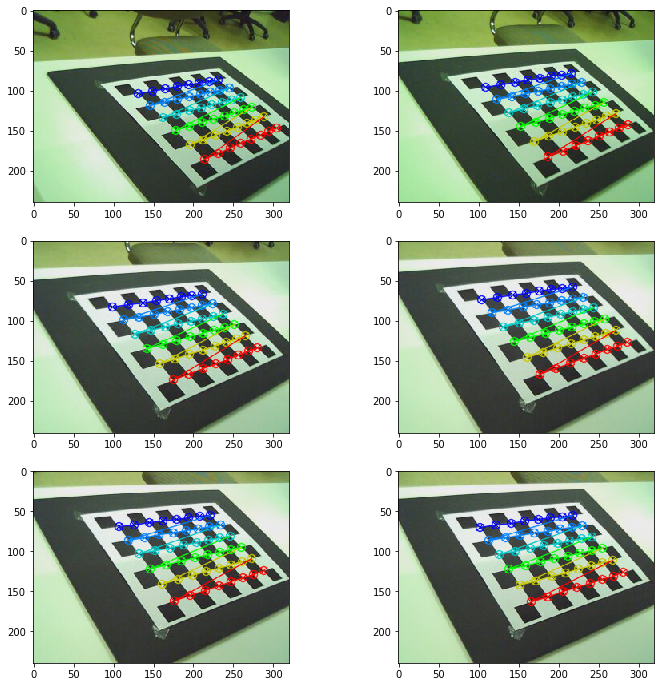

In [7]:
# Dibujamos los puntos del patrón en algunas imágenes izquierda
drawImages(images_left, imgpoints_left, 6)

Para calibrar la cámara, además de las coordenadas de
las esquinas en cada una de las imágenes, se necesitan las
coordenadas tridimensionales de las esquinas en el sistema
de referencia de la escena. Para esta práctica consideraremos que el centro del sistema de referencia, esto es, el
punto de coordenadas $[0, 0, 0]^\top$, es la primera esquina de
la plantilla de calibración detectada en todas las imágenes.
También consideraremos que el eje X corresponde al lado
corto de la plantilla de calibración, y el eje Y al lado largo.
Esta disposición implica que el eje Z apunta en la dirección
normal hacia arriba del plano de calibración.

Para el siguiente ejercicio es muy importante tener en
cuenta que las coordenadas de las esquinas en el sistema de
referencia de la escena deben darse en el mismo orden que
en el que fueron detectadas en cada una de las imágenes.

**Ejercicio 3.** Implementa la función ``get_chessboard_points(chessboard_shape, dx, dy)`` que genere una matriz de NumPy (es decir, un ndarray) de
tamaño $N × 3$ con las coordenadas $(x,y,z)$, resp. (*columna, fila, 0*),  de las esquinas de
la plantilla de calibración en el sistema de referencia de la
escena. $N$ es el número de esquinas de la plantilla.

``chessboard_shape`` es el número de puntos (*columnas, filas*) de la plantilla de calibración. Al igual que
en el Ejercicio 1, debe ser (8, 6). ``dx`` (resp. ``dy``) es el ancho
(resp. alto) de un escaque de la plantilla de calibración.
Para la plantilla utilizada en esta práctica, ambos valores
son 30mm.

In [8]:
# Función que permite calcular los puntos del patrón en coordenadas del sistema real
def get_chessboard_points(chessboard_shape, dx, dy):    
    objp = np.zeros((chessboard_shape[0]*chessboard_shape[1],3), np.float32)
    objp[:,:2] = np.mgrid[range(0,211,30),range(0,151,30)].T.reshape(-1,2)
    return objp

In [9]:
# Puntos del tablero en el sistema de coordenadas de referencia
cb_points = get_chessboard_points((8,6), 30, 30)

**Ejercicio 4.** Calibra la cámara izquierda usando la lista de resultados de ``cv2.findChessboardCorners``
y el conjunto de puntos del modelo dados por ``get_chessboard_points``, del ejercicio anterior.

In [10]:
# Función que permite extraer las esquinas válidas
def extractValid(imgpoints, cb_points):
    valid_corners = []
    for i in range(len(imgpoints)):
        if imgpoints[i] is not None and len(imgpoints[i]) == len(cb_points):
            valid_corners += [np.array(np.squeeze(imgpoints[i], axis=1))]
    num_valid_images = len(valid_corners)
    return valid_corners, num_valid_images

In [11]:
# Esquinas del tablero en las imágenes
valid_corners_left, num_valid_images_left = extractValid(imgpoints_left, cb_points)

In [12]:
# Función que nos permite calibrar una cámara dadas sus esquinas en las imágenes, el número de esquinas, los puntos reales de las esquinas y esas imágenes 
def calibrate(valid_corners, num_valid_images, cb_points, images_left):
    # Prepare input data 
    # object_points: numpy array with dimensions (number_of_images, number_of_points, 3)
    object_points = [cb_points] * num_valid_images
    # image_points: numpy array with dimensions (number_of_images, number_of_points, 2)
    image_points = valid_corners

    assert(len(image_points) == len(object_points))
    
    # Calibrate for square pixels corners standard
    return cv2.calibrateCamera(object_points, image_points, cv2.cvtColor(images_left[-1], cv2.COLOR_RGB2GRAY).shape[::-1], None, None, flags=cv2.CALIB_FIX_ASPECT_RATIO)

In [13]:
# Intrínsecos, vectores de rotación y traslación para la cámara izquierda calibrada
rms_left, intrinsics_left, dist_coeffs_left, rvecs_left, tvecs_left = calibrate(valid_corners_left, num_valid_images_left, cb_points, images_left);
print("Corners standard intrinsics:\n",intrinsics_left)
print("Corners standerd dist_coefs:\n", dist_coeffs_left)
print("rms:", rms_left)

Corners standard intrinsics:
 [[421.74809345   0.         149.35296072]
 [  0.         421.74809345 127.62317999]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs:
 [[-6.28274081e-02 -1.34840082e+00  4.54664504e-03 -6.71148882e-03
   6.82236644e+00]]
rms: 0.09357462031462997


###  1.1 Parámetros intrínsecos

Una de las características intrínsecas de una cámara más fácilmente comprensible es su ángulo de visión o campo
de visión (FOV), o el campo de visión de cualquier región en ella. El campo de visión es la amplitud angular de una
determinada escena y se suele expresar en grados. 

**Ejercicio 5.** Conociendo los intrínsecos K y que la región tiene forma rectangular, su esquina superior izquierda está en la posición (10,10) y tiene un tamaño de (50,50) píxeles, calcula el ángulo de visión diagonal que abarca dicha región.


Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

**Analíticamente**


Matemáticamente se conoce que la formula para calcular el FOV diagonal es:
$\alpha = 2 \arctan \left(\frac{\sqrt{{w}^{2} + {h}^{2}}}{2f}\right)$, donde w y h son el ancho y alto de la region que se quiere calcular y f es el parámetro intrínseco del foco de la cámara. Sustituyendo los datos conocidos en la fórmula:
$\alpha = 2 \arctan \left(\frac{\sqrt{{50}^{2} + {50}^{2}}}{2*421.74809345}\right) = 2 \arctan \left(\frac{70.7106}{843.4961869}\right) $

Esta fórmula se puede deducir de la figura de abajo. Con el triángulo amarillo, conocemos el cateto opuesto (diagonal / 2) y el cateto adyacente (distancia focal). Mediante la arcotangente sacamos el ángulo y el DFOV sería el doble de ese ángulo.

![dfov.PNG](dfov.PNG)

**Implementación**

In [14]:
w = 50
h = 50
alfa = 2 * np.arctan(np.sqrt(w*w + h*h)/2/(intrinsics_left[0][0]))
print(f"FOVD = {alfa} rad = {alfa * 180 /np.pi} grados")

FOVD = 0.16726983070378473 rad = 9.583855339194658 grados


**Ejercicio 6.** Calcula cuánto se ha trasladado la cámara entre las imágenes ``left_002.jpg``  y ``left_0014.jpg``.

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

**Analíticamente**

En este ejercicio, se nos pide calcular cuánto se ha trasladado la cámara entre dos imágenes concretas. Para ello, lo que hay que hacer es coger dos imágenes de las que conocemos sus vectores de translación y rotación particulares, y calcular la translación de uno a otro. 

In [15]:
def diferencia_entre_vectores(r1, r2, t1, t2):
    r = np.dot(r2, r1.T)
    t = np.dot(r2, np.dot(-r1.T, t1)) + t2
    return t, r

def compute_translation(rvec1, tvec1, rvec2, tvec2):
    R_1, _ = cv2.Rodrigues(rvec1)
    R_2, _ = cv2.Rodrigues(rvec2)
    t_1 = tvec1
    t_2 = tvec2

    t, r = diferencia_entre_vectores(R_1, R_2, t_1, t_2)
    norm = np.linalg.norm(t)
    
    return R_1, R_2, t_1, t_2, r, t, norm

In [16]:
R_1, R_2, t_1, t_2, r, t, norm = compute_translation(rvecs_left[2], tvecs_left[2], rvecs_left[14], tvecs_left[14])

print("Rotation matrix of image 2: \n", R_1)
print("Rotation matrix of image 14: \n", R_2)
print("Translation vector of image 2: \n", t_1)
print("Translation vector of image 14: \n", t_2)

print(f"La cámara se ha trasladado entre la imagen 2 y la 14 {norm} mm")

Rotation matrix of image 2: 
 [[ 0.73786311  0.5755977  -0.35248448]
 [-0.19313841  0.68046091  0.70687375]
 [ 0.64672682 -0.45349777  0.61325703]]
Rotation matrix of image 14: 
 [[ 0.91296095  0.26112774 -0.31355159]
 [-0.13652848  0.9196142   0.36833368]
 [ 0.38452864 -0.29346555  0.87522323]]
Translation vector of image 2: 
 [[-59.95195581]
 [-54.46781915]
 [505.09421828]]
Translation vector of image 14: 
 [[-132.87321261]
 [ -91.35182243]
 [ 597.85118447]]
La cámara se ha trasladado entre la imagen 2 y la 14 294.36878402986855 mm


## 2. Par de cámaras estéreo

**Ejercicio 7.** ¿Cuál es la distancia, en milímetros, entre las dos cámaras de par estéreo?

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

Sugerencia: Calibra la cámara derecha usando la secuencia de imágenes del directorio ``right`` y estima dicha distancia.

**Analíticamente**

Lo que hacemos en este caso es calibrar la cámara derecha al igual que hicimos antes.

De todas las imágenes conocemos sus vectores de rotación y traslación al haber calibrado las cámaras. Entonces lo que tenemos que hacer es ir calculando al traslación entre las misma imágenes con cada cámara. De esta forma, sacaremos la traslación en cada imagen y la media nos dara la traslación entre las cámaras.

**Implementación**

In [17]:
# Cargamos las imágenes
images_right = glob.glob("B:/Proyectos/ComputerVision/Práctica2/right/*.jpg")
images_right = load_images(images_right)

# Calculamos los puntos en la imagen
imgpoints_right =computeImagePoints(images_right)
assert(len(imgpoints_right) == 19)

# Miramos cuales son válidos
valid_corners_right, num_valid_images_right = extractValid(imgpoints_right, cb_points)

# Elemininamos manualmente las imágenes que hemos visto que no se cargan correctamente las esquinas
images_right = np.delete(images_right, [1,14], axis=0)

# Calibramos la cámara de la derecha
rms_right, intrinsics_right, dist_coeffs_right, rvecs_right, tvecs_right = calibrate(valid_corners_right, num_valid_images_right, cb_points, images_right);
print("Corners standard intrinsics:\n",intrinsics_right)
print("Corners standerd dist_coefs:\n", dist_coeffs_right)
print("rms:", rms_right)

1 image failed to load
14 image failed to load


C:\Users\César\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Corners standard intrinsics:
 [[429.17398035   0.         143.78670926]
 [  0.         429.17398035 136.49910193]
 [  0.           0.           1.        ]]
Corners standerd dist_coefs:
 [[-0.11152915 -0.30940411  0.00646978 -0.00550512  2.13710905]]
rms: 0.09817237391498956


In [19]:
# Ahora tenemos que ver para la misma imagen con ambas cámaras la translación

# Por lo que iteramos por todas las imagenes y calcumas la translación media
# Como imgs_right es de distinta longitud (17) al haber eliminado las dos imágenes para las que no encontraba las esquinas
# tenemos que hacer este proceso semi automático. Esta sería la correspondencia de los índices entre izquierda y derecha:
# izq =[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18]
# der =[0, 2, 3, 4, 5, 6, 7, 8, 9, 10,11, 12, 13, 15, 16, 17, 18]
#       0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16

translations = []

R_1, R_2, t_1, t_2, r, t, norm = compute_translation(rvecs_left[0], tvecs_left[0], rvecs_right[0], tvecs_right[0])
print(f"Imagen 0: La translación entre la cámara izquierda y la derecha es {norm} mm")
translations.append(norm)

# Manda el orden de la derecha
for i in range(1,13):
    print()
    R_1, R_2, t_1, t_2, r, t, norm = compute_translation(rvecs_left[i+1], tvecs_left[i+1], rvecs_right[i], tvecs_right[i])
    print(f"Imagen {i+1}: La translación entre la cámara izquierda y la derecha es {norm} mm")
    translations.append(norm)
    
# Manda el orden de la derecha
for i in range(13, 17):
    print()
    R_1, R_2, t_1, t_2, r, t, norm = compute_translation(rvecs_left[i+2], tvecs_left[i+2], rvecs_right[i], tvecs_right[i])
    print(f"Imagen {i+2}: La translación entre la cámara izquierda y la derecha es {norm} mm")
    translations.append(norm)
    

print("----------------------------------------------------------------------------")
print(f"La translación media entre la cámara izquierda y la derecha {np.mean(translations)} mm")

Imagen 0: La translación entre la cámara izquierda y la derecha es 61.02745208763444 mm

Imagen 2: La translación entre la cámara izquierda y la derecha es 60.46889954570866 mm

Imagen 3: La translación entre la cámara izquierda y la derecha es 58.737616252770955 mm

Imagen 4: La translación entre la cámara izquierda y la derecha es 60.727663705473134 mm

Imagen 5: La translación entre la cámara izquierda y la derecha es 59.80911394221446 mm

Imagen 6: La translación entre la cámara izquierda y la derecha es 59.25255588389875 mm

Imagen 7: La translación entre la cámara izquierda y la derecha es 61.6189484721913 mm

Imagen 8: La translación entre la cámara izquierda y la derecha es 61.059792933988945 mm

Imagen 9: La translación entre la cámara izquierda y la derecha es 60.28920010081563 mm

Imagen 10: La translación entre la cámara izquierda y la derecha es 59.102707191146564 mm

Imagen 11: La translación entre la cámara izquierda y la derecha es 60.533609384343904 mm

Imagen 12: La t

Se comprueba que tanto la imagen 1 como la imagen 14 no se incluyen en esta operación al no encontrarse las esquinas para la cámra derecha.

## 3. Calibración a partir de una imagen

En esta sección vamos a explotar las relaciones de perpendicularidad que suelen aparecer en las escenas urbanas para calibrar la cámara y extraer información sobre dicha escena.

En el directorio ``building`` hay varias imágenes de un edificio que ha sido tomadas con la misma cámara.

**Ejercicio 7.** Se desea estimar la rotación que ha sufrido la cámara entre las imágenes ``build_001`` y ``build_003``.

Resuelve en primer lugar el ejercicio analíticamente y, posteriormente, implementa dicha respuesta y calcula un resultado numérico.

Sugerencia: En primer lugar estudia si es posible estimar los  intrínsecos de la cámara a partir de dichas imágenes y, a continuación, estima la rotación entre ellas.